# Analyse Unified dataset

In [1]:
%load_ext watermark
%watermark -v -m  -u -n -p pandas,numpy,scanpy,requests,topicpy -a Filippo_Valle -g -r -b -w

2024-05-10 11:10:47.727152: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 11:10:47.814931: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 11:10:48.238614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 11:10:49.936429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Author: Filippo_Valle

Last updated: Fri May 10 2024

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

pandas  : 1.5.0
numpy   : 1.23.5
scanpy  : 1.10.0
requests: 2.28.1
topicpy : 0.3.0

Compiler    : GCC 10.4.0
OS          : Linux
Release     : 6.8.0-31-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

Git hash: a399c709867470be8fc76b273e8c7b2b58051718

Git repo: git@github.com:fvalle1/topics.git

Git branch: HEAD

Watermark: 2.4.3



In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import requests
import json
import os, sys

## Download data

Please download data from [https://doi.org/10.6084/m9.figshare.5330593](https://doi.org/10.6084/m9.figshare.5330593) and save all the files in a directory called *data*

In [3]:
#path/to/files/downloaded/
working_dir = f"{os.getcwd()}"
os.chdir(working_dir)

In [4]:
files = filter(lambda f: "fpkm" in f, os.listdir("data"))

We download files metadate from [GTEx project](gtexportal.org)

In [5]:
df_gtex=pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t', index_col=0)

We then download metadata for TCGA files using [GDC API](https://docs.gdc.cancer.gov/API/Users_Guide/Getting_Started/)

In [6]:
filters = {
    "op": "and",
    "content":[
        {
        "op": "in",
        "content":{
            "field": "cases.project.program.name",
            "value": ["TCGA"]
            }
        }
        
    ]
}
params = {
    "filters": json.dumps(filters),
    "fields": "primary_site,disease_type,submitter_id,project.project_id",
    "format": "TSV",
    "size": "10000000"
    }
response = requests.get("https://api.gdc.cancer.gov/cases", headers = {"Content-Type": "application/json"}, params = params)
with open("files.txt","w") as file:
    file.write(response.content.decode("utf-8"))
df_tcga = pd.read_csv("files.txt", sep='\t').set_index("submitter_id")

We create an empty dataframe to fulfill with data

In [7]:
df=pd.DataFrame()

In [10]:
for file in files:
    df = df.append(pd.read_csv("data/%s"%file, sep='\t', index_col=0).drop('Entrez_Gene_Id', axis=1).transpose(), sort=True)
df = df.transpose()
df = df.dropna(how='any', axis=0) # drop genes not always determined

/tmp/ipykernel_4113113/344467094.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv("data/%s"%file, sep='\t', index_col=0).drop('Entrez_Gene_Id', axis=1).transpose(), sort=True)
/tmp/ipykernel_4113113/344467094.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv("data/%s"%file, sep='\t', index_col=0).drop('Entrez_Gene_Id', axis=1).transpose(), sort=True)
/tmp/ipykernel_4113113/344467094.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv("data/%s"%file, sep='\t', index_col=0).drop('Entrez_Gene_Id', axis=1).transpose(), sort=True)
/tmp/ipykernel_4113113/344467094.py:2: FutureWarning: The frame.append method is deprecated and will be removed fro

We create a file of metadata

In [ ]:
df_files = pd.DataFrame(index=df.columns)

import our helper functions

In [8]:
from unified import get_source, get_status

def get_site(file):
    '''
    Returns GTEX or TCGA primary site
    '''
    if ("df_gtex" not in globals().keys()) or ("df_tcga" not in globals().keys()):
        raise NotImplementedError("Please define datasets with gtex and tcga metadata")
    if 'GTEX' in file:
        return df_gtex.at[file, 'SMTS']
    if 'TCGA' in file:
        return df_tcga.at[file[:12],'primary_site']

In [ ]:
df_files.insert(0, 'primary_site', [get_site(file) for file in df.columns])
df_files.insert(1, 'dataset', [get_source(file) for file in df.columns])
df_files.insert(1, 'status', [get_status(file) for file in df.columns])
df_files["dataset_status"]=df_files["dataset"]+"_"+df_files["status"]
df_files.groupby(["dataset","status"]).count()

Save the DataFrame just created

In [ ]:
df.to_csv("mainTable.csv", index=True, header=True)
df_files.to_csv("files.dat", index=True, header=True)

## Split / shuffle and select

In [ ]:
df = pd.read_csv("mainTable.csv", index_col=0)
df_files = pd.read_csv("files.dat", index_col=0)
df.head(2)

Group together same site with different names

In [13]:
df_files.replace('Uterus, NOS', 'Uterus', inplace=True)
df_files.replace('Bronchus and lung', 'Lung', inplace=True)
df_files.replace('Liver and intrahepatic bile ducts', 'Liver', inplace=True)
df_files.replace('Prostate gland', 'Prostate', inplace=True)
df_files.replace('Thyroid gland', 'Thyroid', inplace=True)
df_files.replace('Base of Tongue', 'Salivary Gland', inplace=True)
df_files.replace('Bones, joints and articular cartilage of other and unspecified sites', 'Salivary Gland', inplace=True)
df_files.replace('Floor of mouth', 'Salivary Gland', inplace=True)
df_files.replace('Gum', 'Salivary Gland', inplace=True)
df_files.replace('Hypopharynx', 'Salivary Gland', inplace=True)
df_files.replace('Larynx', 'Salivary Gland', inplace=True)
df_files.replace('Lip', 'Salivary Gland', inplace=True)
df_files.replace('Oropharynx', 'Salivary Gland', inplace=True)
df_files.replace('Other and ill-defined sites in lip, oral cavity and pharynx', 'Salivary Gland', inplace=True)
df_files.replace('Other and unspecified parts of mouth', 'Salivary Gland', inplace=True)
df_files["tissue_hd"]=df_files["primary_site"]+"_"+df_files["dataset"]
df_files['primary_site'].unique()

array(['Kidney', 'Stomach', 'Prostate', 'Rectosigmoid junction', 'Rectum',
       'Connective, subcutaneous and other soft tissues', 'Colon', 'Lung',
       'Thyroid', 'Corpus uteri', 'Uterus', 'Salivary Gland',
       'Other and unspecified parts of tongue', 'Base of tongue',
       'Tonsil', 'Palate', 'Breast', 'Cervix uteri', 'Esophagus', 'Liver',
       'Other and unspecified parts of biliary tract', 'Bladder',
       'Gallbladder', 'Cervix Uteri'], dtype=object)

In [ ]:
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5903355/
sites_with_enough_statistics = ['Breast', 'Colon', 'Liver', 'Esophagus', 'Prostate', 'Stomach', 'Lung', 'Uterus']

We uniformly sample some samples from the chosen tissues

In [ ]:
rs = np.random.RandomState(seed=42)
samples = pd.DataFrame(columns=df_files.columns)
for site in sites_with_enough_statistics:
    samples = samples.append(df_files[(df_files['primary_site']==site) & (df_files['dataset']=='tcga')].sample(50, random_state=rs))
    samples = samples.append(df_files[(df_files['primary_site']==site) & (df_files['dataset']=='gtex')].sample(50, random_state=rs))

Just a check

In [ ]:
samples.groupby('primary_site').count()

In [ ]:
samples.groupby('dataset').count()

### Split into train and test set

In [ ]:
df[df.columns[~df.columns.isin(samples.index) & df.columns.isin(df_files[df_files["primary_site"].isin(sites_with_enough_statistics)].index)]].to_csv("mainTable_test.csv", index=True, header=True)

In [ ]:
df[df.columns[df.columns.isin(samples.index)]].to_csv("mainTable_train.csv", index=True, header=True)

In [14]:
df_files["tissue_hd"].unique()

array(['Kidney_tcga', 'Stomach_gtex', 'Prostate_tcga',
       'Rectosigmoid junction_tcga', 'Rectum_tcga',
       'Connective, subcutaneous and other soft tissues_tcga',
       'Colon_tcga', 'Lung_tcga', 'Thyroid_tcga', 'Corpus uteri_tcga',
       'Uterus_gtex', 'Salivary Gland_gtex', 'Salivary Gland_tcga',
       'Other and unspecified parts of tongue_tcga',
       'Base of tongue_tcga', 'Tonsil_tcga', 'Palate_tcga', 'Breast_tcga',
       'Cervix uteri_tcga', 'Esophagus_tcga', 'Thyroid_gtex',
       'Stomach_tcga', 'Breast_gtex', 'Esophagus_gtex', 'Liver_tcga',
       'Other and unspecified parts of biliary tract_tcga', 'Uterus_tcga',
       'Bladder_gtex', 'Prostate_gtex', 'Kidney_gtex', 'Liver_gtex',
       'Gallbladder_tcga', 'Bladder_tcga', 'Colon_gtex', 'Lung_gtex',
       'Cervix Uteri_gtex'], dtype=object)

In [15]:
df_files.to_csv("files.dat", index=True, header=True)

# Filtering Highly Variable Genes with *scapy*

In [ ]:
adata = sc.AnnData(df[samples.index].transpose(), obs=samples)
adata_log = sc.pp.log1p(adata, copy=True)

In [ ]:
sc.pp.highly_variable_genes(adata_log, n_top_genes=3000, n_bins=50)

In [ ]:
sc.pl.highly_variable_genes(adata_log, log=True, save='hvg.pdf')

In [ ]:
hvg = adata_log.var[adata_log.var['highly_variable']==True].index
samples = adata_log.obs.index

# Use hSBM

In [ ]:
sys.path.append("/home/jovyan/work/topics/hSBM_Topicmodel/")
from sbmtm import sbmtm

In [ ]:
model = sbmtm()

In [ ]:
model.make_graph_from_BoW_df(df.loc[hvg, samples])

In [ ]:
model.save_graph("graph.xml.gz")

# Analyse clusters

In [1]:
from topicpy.hsbmpy import clusteranalysis
clusteranalysis(working_dir,["tissue_hd", "primary_site", "status"])

2024-04-20 11:45:44.711830: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-20 11:45:44.714698: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-20 11:45:44.752795: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-20 11:45:45.793698: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


NameError: name 'working_dir' is not defined

# Scores

In [5]:
from topicpy.hsbmpy import get_scores,get_scores_shuffled
scores = {}
labels = ["primary_site", "status", "tissue_hd"]
df_files = pd.read_csv("files.dat", index_col=0)
scores['tissues'] = get_scores(working_dir, labels, df_files=df_files, algorithm = "topsbm", verbose=False)[labels[0]]
scores['status'] = get_scores(working_dir, labels, df_files=df_files, algorithm = "topsbm", verbose=False)[labels[1]]
scores['shuffle'] = get_scores_shuffled(working_dir, df_files, label=labels[0], algorithm='topsbm')

In [6]:
from topicpy.hsbmpy import normalise_score
if "mixed" in scores.keys():
    scores.pop("mixed")
norm_scores = scores.copy()
normalise_score(norm_scores, base_algorithm="shuffle")

In [7]:
scores["status"]["h"]=np.array(scores["status"]["h"])/np.array(scores["shuffle"]["h"][:-1])
scores["tissues"]["h"]=np.array(scores["tissues"]["h"])/np.array(scores["shuffle"]["h"][:-1])

/tmp/ipykernel_1533/2281894690.py:1: RuntimeWarning: divide by zero encountered in divide
  scores["status"]["h"]=np.array(scores["status"]["h"])/np.array(scores["shuffle"]["h"][1:])
/tmp/ipykernel_1533/2281894690.py:1: RuntimeWarning: invalid value encountered in divide
  scores["status"]["h"]=np.array(scores["status"]["h"])/np.array(scores["shuffle"]["h"][1:])
/tmp/ipykernel_1533/2281894690.py:2: RuntimeWarning: divide by zero encountered in divide
  scores["tissues"]["h"]=np.array(scores["tissues"]["h"])/np.array(scores["shuffle"]["h"][1:])
/tmp/ipykernel_1533/2281894690.py:2: RuntimeWarning: invalid value encountered in divide
  scores["tissues"]["h"]=np.array(scores["tissues"]["h"])/np.array(scores["shuffle"]["h"][1:])


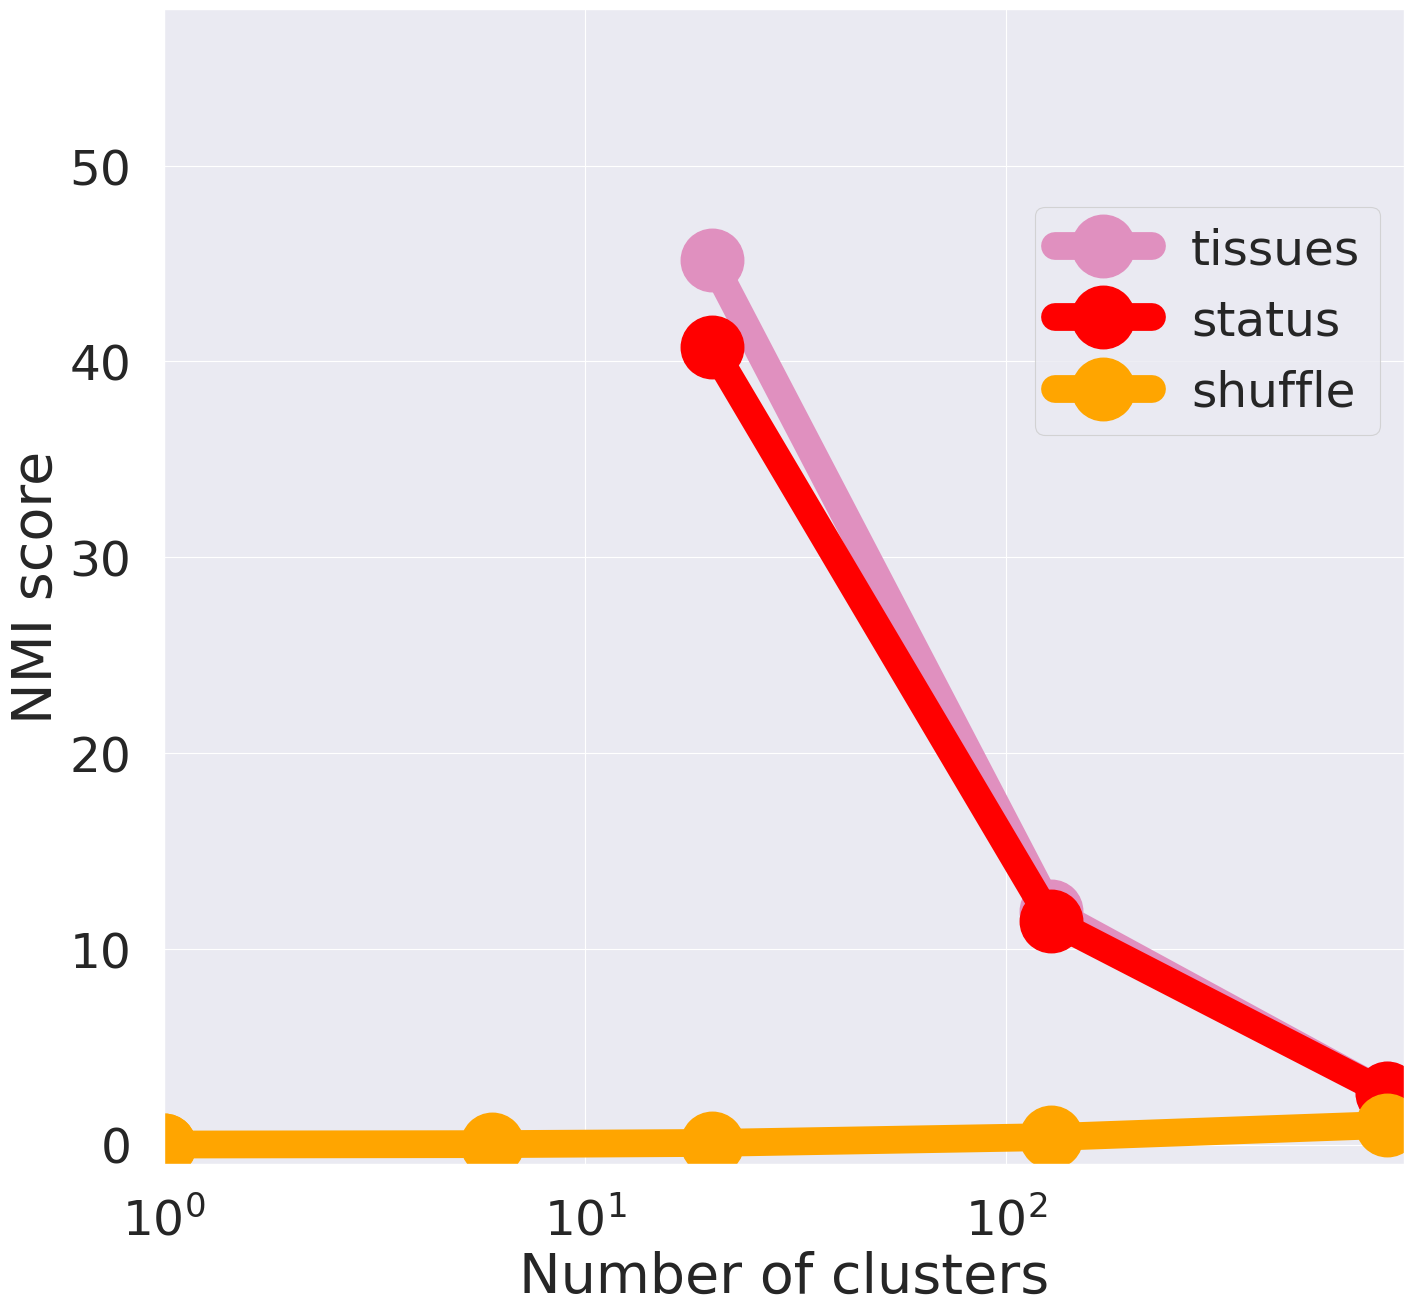

In [9]:
from topicpy.hsbmpy import add_score_lines, customize_metric_plot
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(20,15))
ax = fig.subplots(1)
add_score_lines(ax, scores, V="h", labels=scores.keys())
#ax.set_xscale('linear')
#plt.xlim(1,2000)
plt.ylim(-1,58)
plt.show()
fig.savefig("%s/metric_scores_%s.pdf"%(working_dir,"tissue_hd"))

## LDA

In [10]:
scores = {}
labels = ["primary_site", "tissue_hd"]
df_files = pd.read_csv("files.dat", index_col=0)
scores['tissues'] = get_scores(working_dir, labels, df_files=df_files, algorithm = "lda", verbose=False)[labels[0]]
scores['status'] = get_scores(working_dir, labels, df_files=df_files, algorithm = "lda", verbose=False)[labels[1]]
scores['shuffle'] = get_scores_shuffled(working_dir, df_files, label=labels[0], algorithm='topsbm')

In [11]:
if "mixed" in scores.keys():
    scores.pop("mixed")
norm_scores = scores.copy()
normalise_score(norm_scores, base_algorithm="shuffle")

In [12]:
scores["status"]["h"]=np.array(scores["status"]["h"])/np.array(scores["shuffle"]["h"][:-2])
scores["tissues"]["h"]=np.array(scores["tissues"]["h"])/np.array(scores["shuffle"]["h"][:-2])

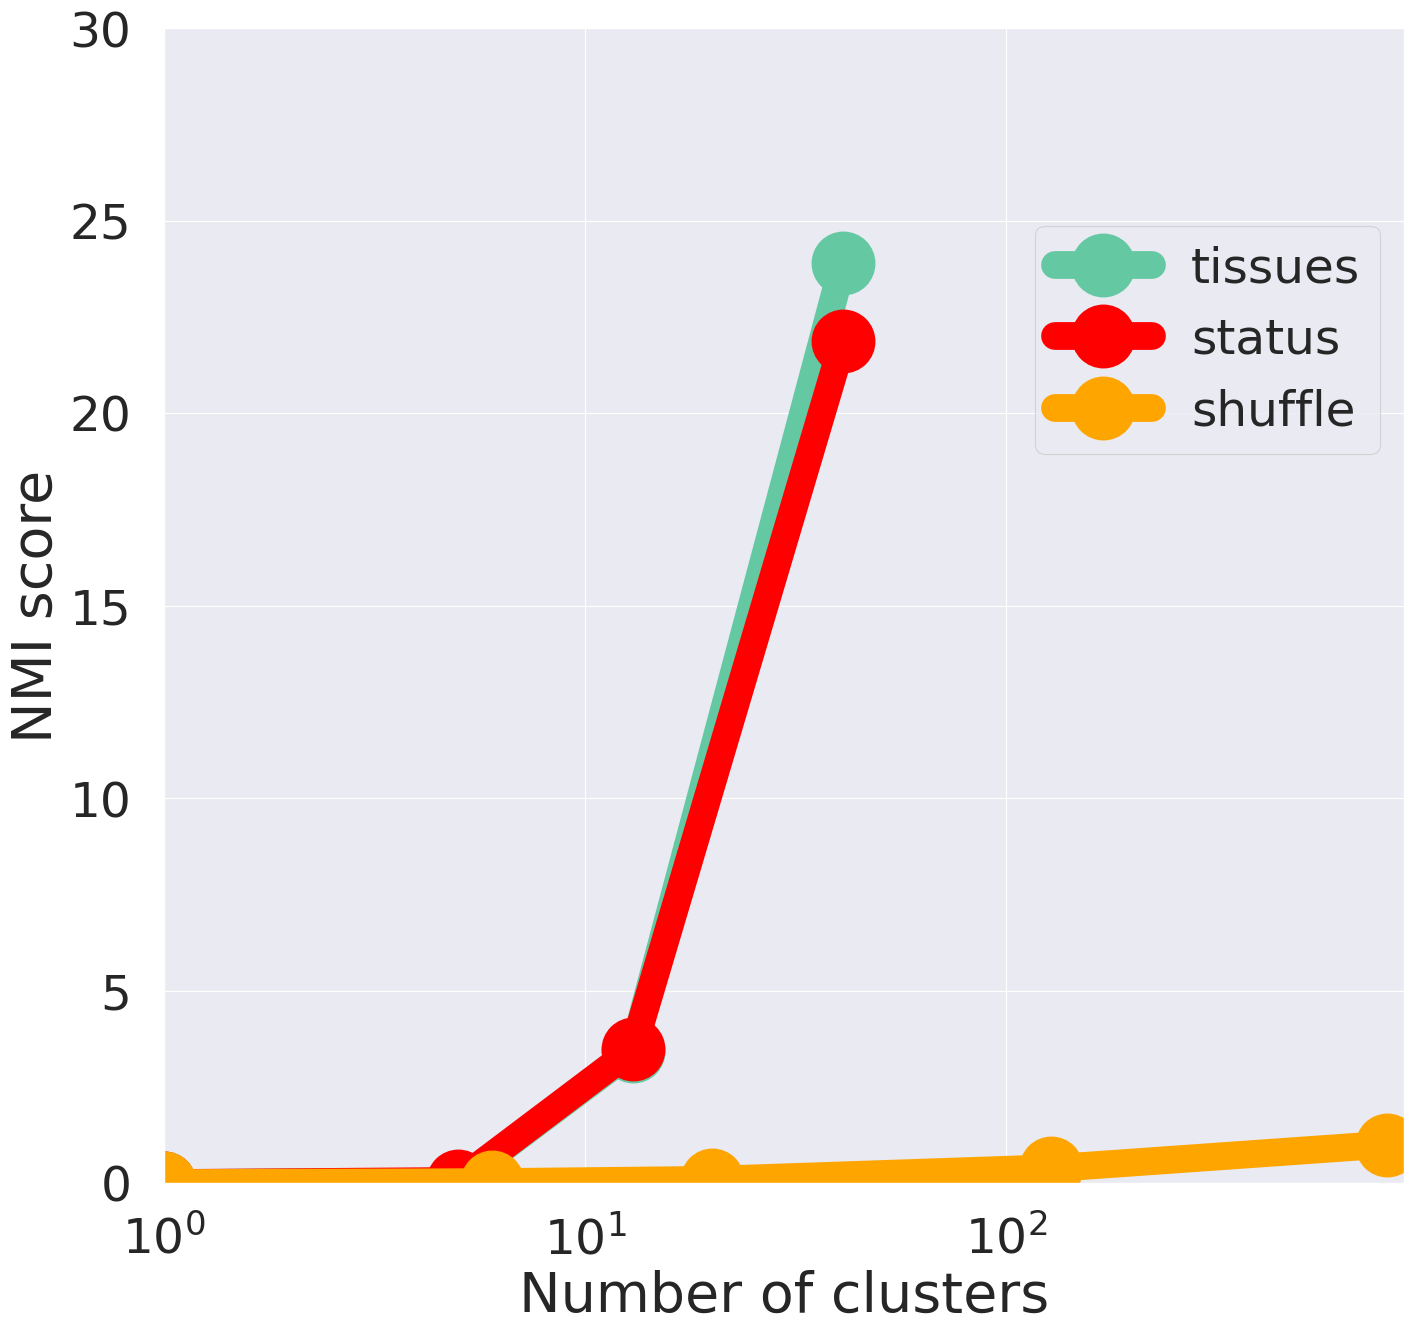

In [13]:
fig=plt.figure(figsize=(20,15))
ax = fig.subplots(1)
add_score_lines(ax, norm_scores, V="h", labels=scores.keys())
#ax.set_yscale('log')
#plt.xlim(1,2000)
plt.ylim(0,30)
plt.show()
fig.savefig("%s/metric_scores_%s_lda.pdf"%(working_dir,"tissue_hd"))